## Exploratory Data Analysis: Network centrality modeling for mobility networks in each city

Create a weighted directional graph and measure how centrality distribution changes with time period and how it compares across cities. Calculate metrics such as:

- Network centrality
- Degree distribution
- Network diameter
- Clustering coefficient
- Number of Hubs
- visualization of network centrality 

Need to think about three metrics for understanding and categorizing the networks:

- Node Importance

Node Centrality: weighted in-degree and out-degree centrality measures to understand 

- Degree centrality: Historically first and conceptually simplest is degree centrality, which is defined as the number of links incident upon a node (i.e., the number of ties that a node has). The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). In the case of a directed network (where ties have direction), we usually define two separate measures of degree centrality, namely indegree and outdegree. Accordingly, indegree is a count of the number of ties directed to the node and outdegree is the number of ties that the node directs to others. When ties are associated to some positive aspects such as friendship or collaboration, indegree is often interpreted as a form of popularity, and outdegree as gregariousness.

<br/>
- Closeness centrality: In a connected graph, the normalized closeness centrality (or closeness) of a node is the average length of the shortest path between the node and all other nodes in the graph. Thus the more central a node is, the closer it is to all other nodes.

<br/>
- Betweenness centrality: Betweenness is a centrality measure of a vertex within a graph (there is also edge betweenness, which is not discussed here). Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. It was introduced as a measure for quantifying the control of a human on the communication between other humans in a social network by Linton Freeman[20] In his conception, vertices that have a high probability to occur on a randomly chosen shortest path between two randomly chosen vertices have a high betweenness.

<br/>
- Eigenvector centrality: Eigenvector centrality (also called eigencentrality) is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. Google's PageRank and the Katz centrality are variants of the eigenvector centrality

- Freeman Centralization: The centralization of any network is a measure of how central its most central node is in relation to how central all the other nodes are.[8] Centralization measures then (a) calculate the sum in differences in centrality between the most central node in a network and all other nodes; and (b) divide this quantity by the theoretically largest such sum of differences in any network of the same size.

Network Topology

see classification section: https://en.wikipedia.org/wiki/Network_topology#Classification

In [1]:
#import packages
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import os
import matplotlib.pyplot as plt

#for Generate trip
import requests
import json



%pylab inline

Populating the interactive namespace from numpy and matplotlib


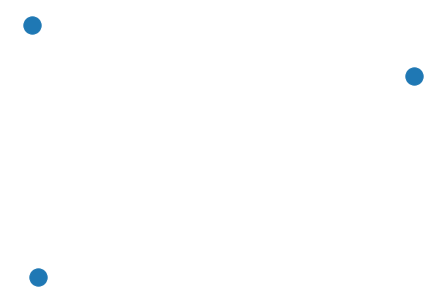

In [2]:
#testing graph
G=nx.Graph()
G.add_node(1)
G.add_nodes_from([2,3])
nx.draw(G)
plt.show()

In [3]:
#set working directory
os.chdir('/projects/mpi/shared/Data')
os.getcwd()

'/projects/mpi/shared/Data'

In [4]:
#import data not run
sf_clean = pd.read_csv('sf_clean.csv')
ny_clean = pd.read_csv('nyc_clean.csv')
la_clean = pd.read_csv('la_clean.csv')
chic_clean = pd.read_csv('chic_clean.csv')

In [100]:
# imort puma data
sf_puma = pd.read_csv('sf_puma.csv',index_col =0)
la_puma = pd.read_csv('la_puma.csv',index_col =0)
ny_puma = pd.read_csv('nyc_puma.csv',index_col =0)
chic_puma = pd.read_csv('chic_puma.csv',index_col =0)

In [5]:
la = {6:'CA'}
sf = {6:'CA'}
ny = {36:'NY',9:'CT',34:'NJ',36:'NY',10:'DE',25:'MA',42:'PA',44:'RI'}
chic = {17:'IL',18:'IN',55:'WI',26:'MI'}

In [89]:
pumaGeo = gpd.read_file('puma.geojson')
pumaGeo['PUMACE10'] = pumaGeo['PUMACE10'] .astype(int)
pumaGeo['STATEFP10'] = pumaGeo['STATEFP10'] .astype(int)
sfpumaGeo = pumaGeo[[c in la.keys() for c in pumaGeo['STATEFP10']]]
lapumaGeo = pumaGeo[[c in sf.keys() for c in pumaGeo['STATEFP10']]]
nypumaGeo = pumaGeo[[c in ny.keys() for c in pumaGeo['STATEFP10']]]
chicpumaGeo = pumaGeo[[c in chic.keys() for c in pumaGeo['STATEFP10']]]

In [94]:
nypumaGeo = nypumaGeo[nypumaGeo['STATEFP10']!=34]

In [95]:
def createPoint (df):   
    df2 = df.copy()
    df2['geometry'] = df['geometry'].centroid
    df2['lon'] = df['geometry'].centroid.x
    df2['lat'] = df['geometry'].centroid.y
    df3  =df2[['PUMACE10','lon','lat']]
    df4 = df3[['PUMACE10','lon','lat']].groupby('PUMACE10').sum()
    ctPos = {c:(df4['lon'][c],df4['lat'][c]) for c in df4.index}
    return (df2,df3,ctPos)
sfpumaPoint,sfPosdf,sfPos = createPoint(sfpumaGeo)
nypumaPoint,nyPosdf,nyPos = createPoint(nypumaGeo)
chicpumaPoint,chicPosdf,chicPos = createPoint(chicpumaGeo)
lapumaPoint,laPosdf,laPos = createPoint(lapumaGeo)

In [34]:
nypumaGeo.STATEFP10.unique()

array([36, 34])

In [36]:
nypumaPoint[nypumaPoint['PUMACE10']==902]

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,lon,lat
65,36,902,3600902,Monroe County (Central)--Rochester City (East)...,G6120,S,35906064,676194,+43.1640468,-077.5876050,POINT (-77.58579215127668 43.16595238690914),-77.585792,43.165952
146,34,902,3400902,Middlesex County (Southwest) PUMA,G6120,S,214847259,3290666,+40.3744446,-074.5190771,POINT (-74.52020043888415 40.37424156352159),-74.520200,40.374242


## Generate Network Graphs for Each City

In [96]:
def create_networkDegree(df,col1,col2,col3):
    '''function to create network x graphs for each df of city movements and returns centrality
    measures and the graph object'''
    mob_graph = nx.MultiDiGraph() #initialize graph
    node_list = list(set(list(df[col1])) & set(list(df[col2]))) #create list of nodes
    mob_graph.add_nodes_from(node_list) #add nodes to teh graph
    
    weighted_edge_list = [] #initialize empty edge list
    for i, j, k in zip(df[col1],df[col2],df[col3]):
        weighted_edge_list.append((i,j,k))
    
    mob_graph.add_weighted_edges_from(weighted_edge_list)
    
    in_deg = nx.in_degree_centrality(mob_graph)
    out_deg = nx.out_degree_centrality(mob_graph)
    centrality = nx.degree_centrality(mob_graph)
    
    centrality_df = pd.DataFrame.from_dict(centrality,orient='index',columns=['centrality'])
    indeg_df = pd.DataFrame.from_dict(in_deg,orient='index',columns=['in_degree'])
    outdeg_df = pd.DataFrame.from_dict(out_deg,orient='index',columns=['out_degree'])
    return mob_graph, indeg_df, outdeg_df, centrality_df

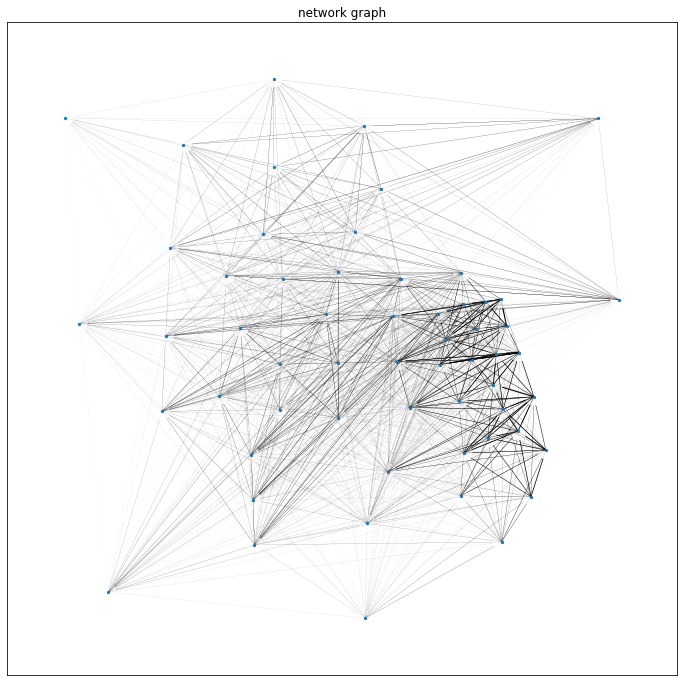

In [193]:
def create_network(df,col1,col2,col3,ctPos,dfGeo):
    fig = plt.figure(3,figsize=(12,12)) 
    ax = fig.add_subplot(111)
    '''function to create network x graphs for each df of city movements and returns centrality
    measures and the graph object'''
    mob_graph = nx.MultiDiGraph() #initialize graph
    node_list = list(set(list(df[col1])) & set(list(df[col2]))) #create list of nodes
    mob_graph.add_nodes_from(node_list) #add nodes to teh graph
    pos=nx.circular_layout(mob_graph) 
    weighted_edge_list = [] #initialize empty edge list
    
    for i, j, k in zip(df[col1],df[col2],df[col3]):
        weighted_edge_list.append((i,j,k))


    
    mob_graph.add_weighted_edges_from(weighted_edge_list)
    
    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in mob_graph.edges(data = True):

        all_weights.append(data['weight'])
        
    #4 b. Get unique weights
    unique_weights = list(set(all_weights))
    
    #scale weights in range 0-1 before assigning color 
    maxWeight=float(max(unique_weights))

    for weight in unique_weights:
        #print(weight)
    #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in mob_graph.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        width = weight*len(node_list)*3.0/sum(all_weights)
        color = [i[2]/maxWeight for i in weighted_edge_list if i[2]==weight]
   
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in mob_graph.edges(data=True) if edge_attr['weight']==weight]
        #nx.draw_networkx_edges(mob_graph,ctPos,edgelist=weighted_edges,width=2,arrowsize = 0.1,edge_color= color)
        nx.draw_networkx_edges(mob_graph,ctPos,edgelist=weighted_edges,width=width,arrowsize = 0.1)


    #Plot the graph
    nx.draw_networkx_nodes(mob_graph,ctPos,node_shape='o',node_size = 5)


    #dfGeo.plot()
    plt.title('network graph')
    plt.show()
create_network(chic_puma,'origin_puma','dest_puma','od_counts',chicPos,chicpumaGeo)

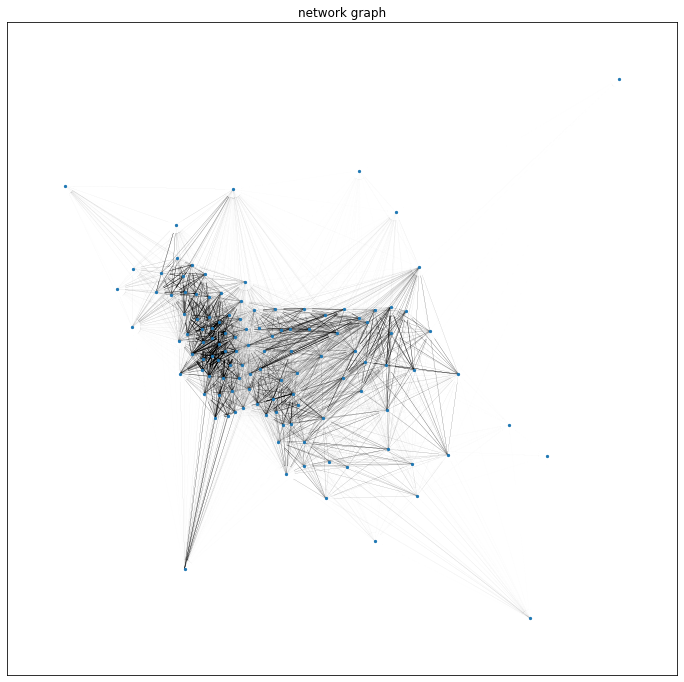

In [194]:
create_network(la_puma,'origin_puma','dest_puma','od_counts',laPos,lapumaGeo)

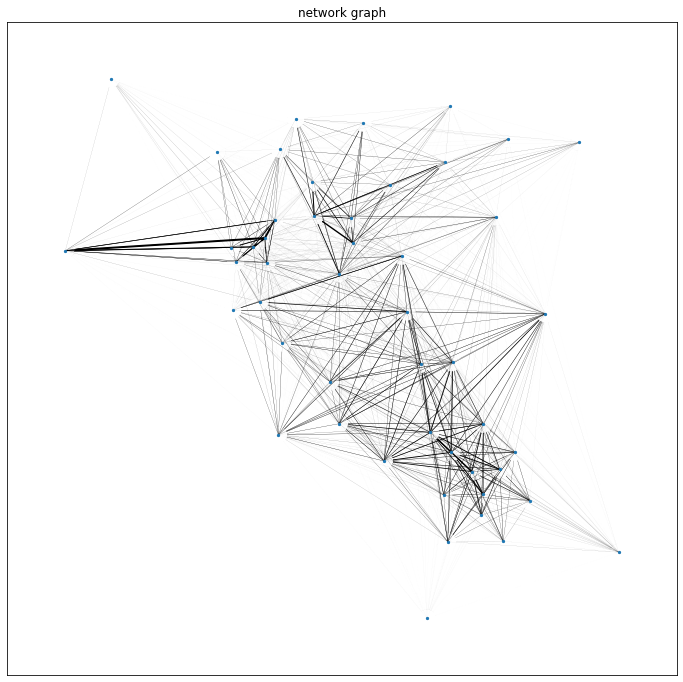

In [195]:
create_network(sf_puma,'origin_puma','dest_puma','od_counts',sfPos,sfpumaGeo)

In [ ]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
# nypumaGeo.plot(ax = ax,color = 'lightgrey')
nypumaPoint.plot(ax = ax)


In [98]:
nyPos

{100: (-75.06896995927985, 44.49639070952038),
 200: (-74.0935868047488, 44.22500140297716),
 300: (-73.64881118420794, 43.443549424758736),
 401: (-75.15248356940334, 43.41059617195648),
 402: (-75.38474749957109, 43.1410651748752),
 403: (-74.86670738449168, 42.662251181235156),
 500: (-75.80534167076846, 43.91125509726132),
 600: (-76.20868182352815, 43.46388727902971),
 701: (-76.14357222885245, 43.04091165797241),
 702: (-76.2541910437544, 43.165825130976735),
 703: (-76.168677141664, 43.038600488917766),
 704: (-76.45475881717908, 42.977205662226716),
 800: (-76.99916322590848, 43.20637135240705),
 901: (-77.47189623262554, 43.197556057409045),
 902: (-77.58579215127668, 43.16595238690914),
 903: (-77.64125537626904, 43.16395396067699),
 904: (-77.70204530547242, 43.22626889022849),
 905: (-77.72115731696083, 43.3792466943708),
 906: (-77.5643898548408, 43.039852006635186),
 1000: (-78.21663751468235, 43.23894591817483),
 1101: (-78.92803382235732, 43.09011161352395),
 1102: (-78

In [200]:
#filtered_dict = {k:v for k,v in d.iteritems() if filter_string in k}
# filter by longitude manually
nyPos1 ={k:v for k,v in nyPos.items() if v[0]>-76}




In [201]:
ny_puma.shape

(12344, 3)

In [202]:
# filter the ny_puma by myPos
ny_puma1 = ny_puma[[x&y for x,y in zip(([c in nyPos1.keys() for c in ny_puma['origin_puma']]),([c in nyPos1.keys() for c in ny_puma['dest_puma']]))]]

In [203]:
ny_puma1.shape

(5855, 3)

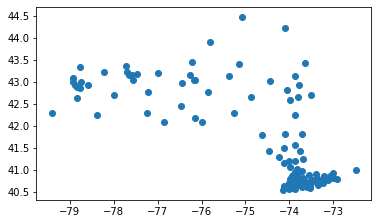

In [204]:
nypumaPoint.plot()

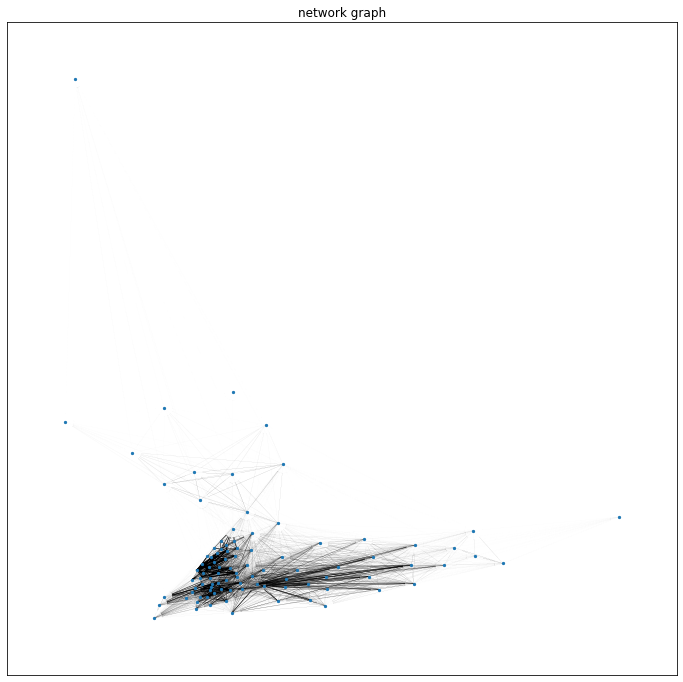

In [205]:
create_network(ny_puma1,'origin_puma','dest_puma','od_counts',nyPos1,nypumaGeo)

In [206]:
#generate graphs for each city
nyc_graph, nyc_in_deg, nyc_out_deg, nyc_centrality = create_networkDegree(nyc_puma,'origin_puma','dest_puma','od_counts')
chic_graph, chic_in_deg, chic_out_deg, chic_centrality = create_networkDegree(chic_puma,'origin_puma','dest_puma','od_counts')
sf_graph, sf_in_deg, sf_out_deg, sf_centrality = create_networkDegree(sf_puma,'origin_puma','dest_puma','od_counts')
la_graph, la_in_deg, la_out_deg, la_centrality = create_networkDegree(la_puma,'origin_puma','dest_puma','od_counts')

NameError: name 'create_networkDegree' is not defined

### Visualize the Centrality Metrics

In [ ]:
#distribution plots of distance travelled 
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)

ax1.set_ylabel("Frequency")
ax1.set_xlabel("In-Degree Centrality")
ax1.set_title("NYC Mobility Network Degree Distribution")
ax1.hist(nyc_in_deg['in_degree'],bins=50,color='green')
ax1.text(x=0.5,y=650,s="Mean in-degree centrality = {}".format(round(nyc_in_deg['in_degree'].mean(),2)))
ax1.text(x=0.5,y=620,s="Number of Network Nodes = {}".format(nyc_in_deg.shape[0]))

ax2 = fig.add_subplot(222)

ax2.set_ylabel("Frequency")
ax2.set_xlabel("In-Degree Centrality")
ax2.set_title("LA Mobility Network Degree Distribution")
ax2.hist(la_in_deg['in_degree'],bins=50,color='red')
ax2.text(x=0.6,y=400,s="Mean in-degree centrality = {}".format(round(la_in_deg['in_degree'].mean(),2)))
ax2.text(x=0.6,y=380,s="Number of Network Nodes = {}".format(la_in_deg.shape[0]))

ax3 = fig.add_subplot(223)

ax3.set_ylabel("Frequency")
ax3.set_xlabel("In-Degree Centrality")
ax3.set_title("SF Mobility Network Degree Distribution")
ax3.hist(sf_in_deg['in_degree'],bins=50,color='yellow')
ax3.text(x=0.8,y=110,s="Mean in-degree centrality = {}".format(round(sf_in_deg['in_degree'].mean(),2)))
ax3.text(x=0.8,y=100,s="Number of Network Nodes = {}".format(sf_in_deg.shape[0]))

ax4 = fig.add_subplot(224)

ax4.set_ylabel("Frequency")
ax4.set_xlabel("In-Degree Centrality")
ax4.set_title("Chicago Mobility Network Degree Distribution")
ax4.hist(chic_in_deg['in_degree'],bins=50,color='blue')
ax4.text(x=0.6,y=200,s="Mean in-degree centrality = {}".format(round(chic_in_deg['in_degree'].mean(),2)))
ax4.text(x=0.6,y=190,s="Number of Network Nodes = {}".format(chic_in_deg.shape[0]))

plt.plot()